In [4]:
import numpy as np
from datasets import load_dataset

xlsum = load_dataset('anakib1/mango-truth', 'xlsum')['train']

In [5]:
labler = xlsum.features['label']
human = xlsum.filter(lambda x: x['label'] == labler.str2int('human')).select(range(1000))
ai = xlsum.filter(lambda x: x['label'] == labler.str2int('gpt-4o-mini'))

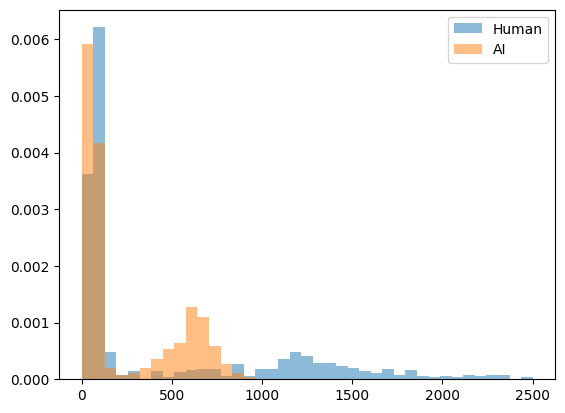

In [6]:
from matplotlib import pyplot as plt

bins = np.linspace(0, 2500, 40)
plt.hist(human.map(lambda x: {"length": len(x['output'].split())})['length'], bins=bins, density=True, label='Human',
         alpha=0.5)
plt.hist(ai.map(lambda x: {"length": len(x['output'].split())})['length'], bins=bins, density=True, label='AI',
         alpha=0.5)
plt.legend()

In [8]:
from dotenv import load_dotenv

load_dotenv()
from openai import OpenAI

openai = OpenAI()


def get_perplexity_by_openai(text):
    response = openai.completions.create(
        model='babbage-002',
        prompt="<|endoftext|>" + text,
        max_tokens=0,
        echo=True,
        logprobs=1,
    )

    logprobs = np.array(response.choices[0].logprobs.token_logprobs[1:])
    return np.exp(-np.mean(logprobs))


In [72]:
from tqdm.auto import tqdm

human_perplexities = np.array([get_perplexity_by_openai(x['output']) for x in tqdm(human.take(100))])
llm_perplexities = np.array([get_perplexity_by_openai(x['output']) for x in tqdm(ai.take(100))])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Human Mean Perplexity: 584.0563063867845
AI Mean Perplexity: 360.5124574967811


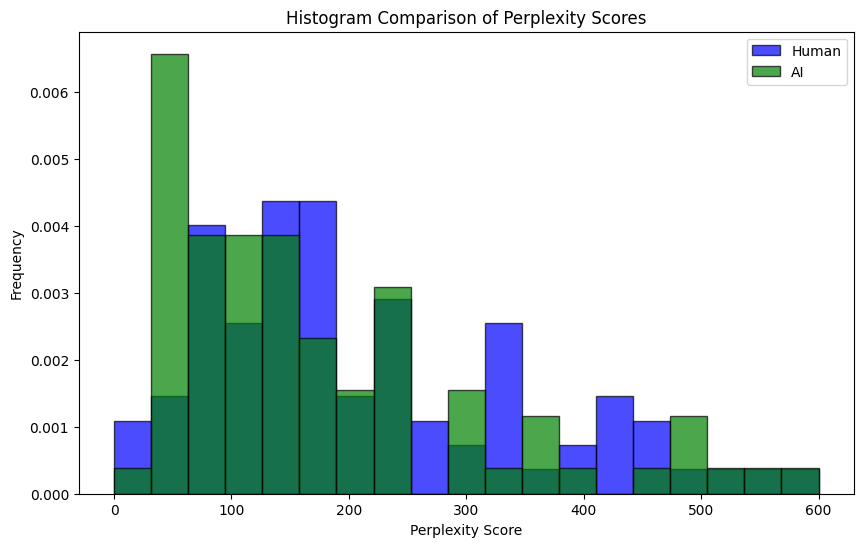

In [16]:
import matplotlib.pyplot as plt

bins = np.linspace(np.percentile(np.concat([human_perplexities, llm_perplexities]), 1),
                   np.percentile(np.concat([human_perplexities, llm_perplexities]), 99), 50)

bins = np.linspace(0, 600, 50)

print(f"Human Mean Perplexity: {human_perplexities.mean()}")
print(f"AI Mean Perplexity: {llm_perplexities.mean()}")

plt.figure(figsize=(10, 6))

plt.hist(human_perplexities, bins=bins, alpha=0.7, label='Human', color='blue', edgecolor='black', density=True)
plt.hist(llm_perplexities, bins=bins, alpha=0.7, label='AI', color='green', edgecolor='black', density=True)

plt.xlabel('Perplexity Score')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Perplexity Scores')
plt.legend()
plt.show()

In [93]:
from sklearn.metrics import f1_score, roc_auc_score

perplexities = np.concat([human_perplexities, llm_perplexities])
thresholds = np.sort(perplexities)
labels = np.concatenate([np.ones(len(human_perplexities)), np.zeros(len(llm_perplexities))]).astype(int)

max_f1 = 0
optimal_C = thresholds[0]

for C in thresholds:
    predictions = (perplexities > C).astype(int)
    f1 = f1_score(labels, predictions)

    if f1 > max_f1:
        max_f1 = f1
        optimal_C = C


def safe_sigmoid(x):
    positive = x >= 0
    negative = ~positive
    result = np.zeros_like(x, dtype=np.float64)

    result[positive] = 1 / (1 + np.exp(-x[positive]))
    result[negative] = np.exp(x[negative]) / (1 + np.exp(x[negative]))

    return result


max_roc = 0
optimal_K = None
for k in np.linspace(0.0001, 1, 1000):
    probabilities = safe_sigmoid(k * (np.array(perplexities) - optimal_C))

    roc = roc_auc_score(labels, probabilities)
    if roc > max_roc:
        max_roc = roc
        optimal_K = k

In [45]:
from detectors.perplexity.model import PerplexityModel

model = PerplexityModel('babbage-002', optimal_C, optimal_K)